In [2]:
!wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0TUZEN/lime.zip"

!wget"https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0TUZEN/shap.zip"

--2024-05-28 13:17:49--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0TUZEN/lime.zip
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 291099 (284K) [application/zip]
Saving to: ‘lime.zip.1’

lime.zip.1          100%[===================>] 284.28K  --.-KB/s    in 0.03s   

2024-05-28 13:17:49 (9.99 MB/s) - ‘lime.zip.1’ saved [291099/291099]

/bin/bash: line 1: wgethttps://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0TUZEN/shap.zip: No such file or directory


In [3]:
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits, load_wine
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import lime
from lime import lime_tabular
import shap

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
# This function will allow us to easily plot data taking in x values, y values, and a title
def plotter(x, y, title):
    plt.plot(x, y)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.show()

In [5]:
#!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0TUZEN/Training_games.csv'
Game_all = pd.read_csv('Training_games.csv')
Game_all.head()

--2024-05-28 13:17:56--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0TUZEN/Training_games.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58950 (58K) [text/csv]
Saving to: ‘Training_games.csv’

Training_games.csv  100%[===================>]  57.57K  --.-KB/s    in 0.07s   

2024-05-28 13:17:57 (806 KB/s) - ‘Training_games.csv’ saved [58950/58950]



,Unnamed: 0,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2022-01-02,Gabon,Burkina Faso,0.0,3.0,Friendly,Dubai,United Arab Emirates,True
1,2022-01-02,Sudan,Zimbabwe,0.0,0.0,Friendly,Yaoundé,Cameroon,True
2,2022-01-03,Rwanda,Guinea,3.0,0.0,Friendly,Kigali,Rwanda,False
3,2022-01-04,Mauritania,Gabon,1.0,1.0,Friendly,Dubai,United Arab Emirates,True
4,2022-01-05,Algeria,Ghana,3.0,0.0,Friendly,Al Rayyan,Qatar,True


In [6]:
#Team = pd.DataFrame({'team':['Senegal','Qatar','Netherlands','Ecuador','Iran','England','United States','Wales','Argentina','Saudi Arabia','Mexico','Poland','Denmark','Tunisia','France','Australia','Germany','Japan','Spain','Costa Rica','Morocco','Croatia','Belgium','Canada','Switzerland','Cameroon','Brazil','Serbia','Uruguay','Korea Republic','Portugal','Ghana']})
Teams = ['Senegal','Qatar','Netherlands','Ecuador','Iran','England','United States','Wales','Argentina','Saudi Arabia','Mexico','Poland','Denmark','Tunisia','France','Peru','Germany','Japan','Spain','Costa Rica','Morocco','Croatia','Belgium','Canada','Switzerland','Cameroon','Brazil','Serbia','Uruguay','Korea Republic','Portugal','Ghana']

In [7]:
Game_all = Game_all.replace('South Korea','Korea Republic')
Game_all.head()

,Unnamed: 0,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2022-01-02,Gabon,Burkina Faso,0.0,3.0,Friendly,Dubai,United Arab Emirates,True
1,2022-01-02,Sudan,Zimbabwe,0.0,0.0,Friendly,Yaoundé,Cameroon,True
2,2022-01-03,Rwanda,Guinea,3.0,0.0,Friendly,Kigali,Rwanda,False
3,2022-01-04,Mauritania,Gabon,1.0,1.0,Friendly,Dubai,United Arab Emirates,True
4,2022-01-05,Algeria,Ghana,3.0,0.0,Friendly,Al Rayyan,Qatar,True


In [8]:
Game_used = Game_all.drop(Game_all[(~Game_all['home_team'].isin(Teams)) | (~Game_all['away_team'].isin(Teams)) ].index)
Game_used.count()
Game_used

,Unnamed: 0,home_team,away_team,home_score,away_score,tournament,city,country,neutral
10,2022-01-10,Morocco,Ghana,1.0,0.0,African Cup of Nations,Yaoundé,Cameroon,True
72,2022-01-27,Ecuador,Brazil,1.0,1.0,FIFA World Cup qualification,Quito,Ecuador,False
87,2022-01-30,Canada,United States,2.0,0.0,FIFA World Cup qualification,Hamilton,Canada,False
88,2022-01-30,Mexico,Costa Rica,0.0,0.0,FIFA World Cup qualification,Mexico City,Mexico,False
100,2022-02-01,Japan,Saudi Arabia,2.0,0.0,FIFA World Cup qualification,Saitama,Japan,False
...,...,...,...,...,...,...,...,...,...
709,2022-09-27,Ecuador,Japan,0.0,0.0,Kirin Challenge Cup,Düsseldorf,Germany,True
715,2022-09-27,Iran,Senegal,1.0,1.0,Friendly,Maria Enzersdorf,Austria,True
717,2022-09-27,Korea Republic,Cameroon,1.0,0.0,Friendly,Seoul,Korea Republic,False
727,2022-09-27,Saudi Arabia,United States,0.0,0.0,Friendly,Murcia,Spain,True


In [9]:
list3 = list(Game_used['home_team'].unique()) + list(set(Game_used['away_team'].unique()) - set(Game_used['home_team'].unique()))
list(set(list3) - set(Teams))

[]

In [10]:
#!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0TUZEN/Player.csv'
Player_all = pd.read_csv('Player.csv')
Player_all.head()

--2024-05-28 13:17:57--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0TUZEN/Player.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4633038 (4.4M) [text/csv]
Saving to: ‘Player.csv.1’

Player.csv.1        100%[===================>]   4.42M  3.80MB/s    in 1.2s    

2024-05-28 13:17:59 (3.80 MB/s) - ‘Player.csv.1’ saved [4633038/4633038]



,Name,FullName,Age,Height,Weight,Nationality,Overall,Positions,PreferredFoot,IntReputation,...,LMRating,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating
0,L. Messi,Lionel Messi,35,169,67,Argentina,91,RW,Left,5,...,91,88,91,67,66,67,62,53,62,22
1,K. Benzema,Karim Benzema,34,185,81,France,91,"CF,ST",Right,4,...,89,84,89,67,67,67,63,58,63,21
2,R. Lewandowski,Robert Lewandowski,33,185,81,Poland,91,ST,Right,5,...,86,83,86,67,69,67,64,63,64,22
3,K. De Bruyne,Kevin De Bruyne,31,181,70,Belgium,91,"CM,CAM",Right,4,...,91,91,91,82,82,82,78,72,78,24
4,K. Mbappé,Kylian Mbappé,23,182,73,France,91,"ST,LW",Right,4,...,92,84,92,70,66,70,66,57,66,21


In [11]:
for i in range(len(Teams)):
    print(Teams[i],Player_all.loc[Player_all['Nationality'] == Teams[i]]['Name'].count())

Senegal 132
Qatar 30
Netherlands 428
Ecuador 176
Iran 16
England 1632
United States 437
Wales 164
Argentina 937
Saudi Arabia 331
Mexico 60
Poland 390
Denmark 318
Tunisia 31
France 963
Peru 151
Germany 1204
Japan 80
Spain 1074
Costa Rica 21
Morocco 106
Croatia 167
Belgium 318
Canada 82
Switzerland 218
Cameroon 76
Brazil 728
Serbia 103
Uruguay 278
Korea Republic 319
Portugal 382
Ghana 135


In [12]:
Player_all.loc[Player_all.FullName == 'Karim Benzema']

,Name,FullName,Age,Height,Weight,Nationality,Overall,Positions,PreferredFoot,IntReputation,...,LMRating,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating
1,K. Benzema,Karim Benzema,34,185,81,France,91,"CF,ST",Right,4,...,89,84,89,67,67,67,63,58,63,21


In [13]:
#!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0TUZEN/Training_game_62.csv'
Game_63 = pd.read_csv('Training_game_63.csv')

#show the first player in the first of the 62 training games
Player_all.loc[(Game_63.loc[0]['Player1'])]

--2024-05-28 13:17:59--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0TUZEN/Training_game_62.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.


HTTP request sent, awaiting response... 200 OK
Length: 8669 (8.5K) [text/csv]
Saving to: ‘Training_game_62.csv.1’

Training_game_62.cs 100%[===================>]   8.47K  --.-KB/s    in 0s      

2024-05-28 13:18:00 (83.9 MB/s) - ‘Training_game_62.csv.1’ saved [8669/8669]



Name              Y. Bounou
FullName     Yassine Bounou
Age                      31
Height                  192
Weight                   78
                  ...      
RWBRating                30
LBRating                 29
CBRating                 30
RBRating                 29
GKRating                 84
Name: 100, Length: 71, dtype: object

In [27]:
team_age=[]
for j in range(63):
    
    # Get the team1 and team2 player index from the Team DataFrame
    team1_index = list(Game_63.loc[j][8:19])
    team2_index = list(Game_63.loc[j][19:30])
    
    # Average of the team age
    temp1 = Player_all.iloc[team1_index]['Age'].mean()
    temp2 = Player_all.iloc[team2_index]['Age'].mean()
    team_age.append([temp1,temp2])
    
# Create the DataFrame for the average age    
cols = ['Average_age1','Average_age2']
Train_df_age = pd.DataFrame(team_age, columns=cols)
Train_df_age.head()

IndexError: positional indexers are out-of-bounds

In [ ]:
team_overall=[]
for j in range(63):
    
    # Get the full team1 and team2 player index from the Team DataFrame
    team_index = list(Game_63.loc[j][8:30])
    
    # The team1 and team2 player overall from the Team DataFrame
    temp3 = Player_all.iloc[team_index]['Overall']
    team_overall.append(list(temp3))
    
# Create the DataFrame for the player overall    
cols = []
for i in range(22):
    cols.append('Player'+str(i+1)+'_overall') 
Train_df_overall = pd.DataFrame(team_overall, columns=cols)
Train_df_overall.head()

,Player1_overall,Player2_overall,Player3_overall,Player4_overall,Player5_overall,Player6_overall,Player7_overall,Player8_overall,Player9_overall,Player10_overall,...,Player13_overall,Player14_overall,Player15_overall,Player16_overall,Player17_overall,Player18_overall,Player19_overall,Player20_overall,Player21_overall,Player22_overall
0,84,84,77,80,74,71,70,73,74,77,...,72,76,77,70,84,75,71,75,75,75
1,72,69,78,69,79,66,72,70,77,75,...,78,84,86,80,83,80,89,86,81,82
2,77,70,69,71,70,72,71,72,74,79,...,77,73,74,74,74,76,80,74,71,82
3,80,76,77,76,75,80,65,76,81,76,...,74,69,67,62,71,71,68,67,71,70
4,72,79,75,74,74,78,78,71,76,75,...,72,68,67,73,66,69,66,70,77,65


In [ ]:
Train_df=pd.concat([Train_df_age, Train_df_overall],axis=1)

In [ ]:
Train_df.head()

,Average_age1,Average_age2,Player1_overall,Player2_overall,Player3_overall,Player4_overall,Player5_overall,Player6_overall,Player7_overall,Player8_overall,...,Player13_overall,Player14_overall,Player15_overall,Player16_overall,Player17_overall,Player18_overall,Player19_overall,Player20_overall,Player21_overall,Player22_overall
0,26.181818,27.000000,84,84,77,80,74,71,70,73,...,72,76,77,70,84,75,71,75,75,75
1,25.545455,27.454545,72,69,78,69,79,66,72,70,...,78,84,86,80,83,80,89,86,81,82
2,27.272727,23.545455,77,70,69,71,70,72,71,72,...,77,73,74,74,74,76,80,74,71,82
3,27.181818,28.090909,80,76,77,76,75,80,65,76,...,74,69,67,62,71,71,68,67,71,70
4,28.090909,27.454545,72,79,75,74,74,78,78,71,...,72,68,67,73,66,69,66,70,77,65


In [ ]:
Result_training = []
Result_totalgoal = []
Result_netgoal = []
for j in range(63):
    Result_training.append(Game_63.loc[j]['Result'])
    Result_totalgoal.append(Game_63.loc[j]['Netgoal'])
    Result_netgoal.append(Game_63.loc[j]['Goal_total'])
np.array(Result_training)
np.array(Result_totalgoal)
np.array(Result_netgoal)

array([1, 2, 2, 0, 2, 0, 1, 2, 2, 3, 6, 1, 2, 3, 2, 2, 3, 3, 2, 6, 3, 3,
       5, 4, 0, 0, 2, 1, 2, 3, 7, 1, 1, 5, 2, 4, 1, 1, 5, 1, 3, 3, 3, 2,
       2, 3, 2, 1, 4, 0, 3, 2, 1, 1, 6, 6, 2, 0, 2, 1, 0, 1])

In [ ]:
#!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0TUZEN/matches_group.csv'
match = pd.read_csv('matches_group.csv')
match.head()

--2024-05-28 02:38:52--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0TUZEN/matches_group.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2889 (2.8K) [text/csv]
Saving to: ‘matches_group.csv.1’

matches_group.csv.1 100%[===================>]   2.82K  --.-KB/s    in 0s      

2024-05-28 02:38:53 (22.8 MB/s) - ‘matches_group.csv.1’ saved [2889/2889]



,match,date,country1,country2,phase,Unnamed: 5,Unnamed: 6
0,1,21/11/2022,Qatar,Ecuador,group matches,NaN,NaN
1,2,21/11/2022,Senegal,Netherlands,group matches,NaN,NaN
2,3,21/11/2022,England,Iran,group matches,NaN,NaN
3,4,21/11/2022,United States,Wales,group matches,NaN,NaN
4,5,22/11/2022,France,Australia,group matches,NaN,NaN


In [ ]:
#!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0TUZEN/Teams.csv'
Team = pd.read_csv('Teams.csv')
Team.head()

--2024-05-28 02:38:53--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0TUZEN/Teams.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2083 (2.0K) [text/csv]
Saving to: ‘Teams.csv.1’

Teams.csv.1         100%[===================>]   2.03K  --.-KB/s    in 0s      

2024-05-28 02:38:53 (77.5 MB/s) - ‘Teams.csv.1’ saved [2083/2083]



,Unnamed: 0,Team,Group,Player1,Player2,Player3,Player4,Player5,Player6,Player7,Player8,Player9,Player10,Player11
0,1,Senegal,A,62,2931,40,1070,2638,2096,248,906,1974,545,15
1,2,Qatar,A,6227,5537,6460,9282,10707,7036,4160,3505,10006,3300,1086
2,3,Netherlands,A,428,84,9,405,237,237,272,42,397,75,481
3,4,Ecuador,A,2979,5570,689,5447,515,9016,3009,4427,990,1730,1758
4,5,Iran,B,3568,3353,14410,6635,3068,10316,2689,3143,4477,296,489


In [ ]:
team_age=[]
for j in range(48):
    
    # Get the team1 and team2 player index from the Team DataFrame
    team1_index = list(Team.loc[Team['Team'] == match['country1'][j]].iloc[0,3:])
    team2_index = list(Team.loc[Team['Team'] == match['country2'][j]].iloc[0,3:])
    
    # Average of the team age
    temp1 = Player_all.iloc[team1_index]['Age'].mean()
    temp2 = Player_all.iloc[team2_index]['Age'].mean()
    team_age.append([temp1,temp2])

# Create the DataFrame for the average age
cols = ['Average_age1','Average_age2']
Predic_df_age = pd.DataFrame(team_age, columns=cols)
Predic_df_age.head()

,Average_age1,Average_age2
0,27.000000,25.545455
1,28.090909,26.272727
2,25.909091,28.181818
3,24.363636,24.909091
4,27.181818,26.909091


In [ ]:
team_overall=[]
for j in range(48):
    
    # Get the full team1 and team2 player index from the Team DataFrame
    team_index = list(Team.loc[Team['Team'] == match['country1'][j]].iloc[0,3:]) + list(Team.loc[Team['Team'] == match['country2'][j]].iloc[0,3:])
    
    # The team1 and team2 player overall from the Team DataFrame
    temp3 = Player_all.iloc[team_index]['Overall']
    team_overall.append(list(temp3))

# Create the DataFrame for the player overall
cols = []
for i in range(22):
    cols.append('Player'+str(i+1)+'_overall') 
Predic_df_overall = pd.DataFrame(team_overall, columns=cols)
Predic_df_overall.head()

,Player1_overall,Player2_overall,Player3_overall,Player4_overall,Player5_overall,Player6_overall,Player7_overall,Player8_overall,Player9_overall,Player10_overall,...,Player13_overall,Player14_overall,Player15_overall,Player16_overall,Player17_overall,Player18_overall,Player19_overall,Player20_overall,Player21_overall,Player22_overall
0,68,69,68,66,65,68,71,72,65,72,...,69,78,69,79,66,72,70,77,75,75
1,86,73,87,77,73,74,82,77,74,79,...,85,90,80,82,82,82,87,80,85,80
2,81,83,80,85,84,84,84,80,85,86,...,72,61,68,72,65,73,72,70,81,80
3,77,70,76,73,77,72,76,80,77,69,...,70,72,68,75,67,66,71,75,77,81
4,87,84,83,84,86,85,82,85,83,91,...,69,72,72,65,72,66,67,70,72,67


In [ ]:
Predicting_df=pd.concat([Predic_df_age, Predic_df_overall],axis=1)

In [ ]:
Predicting_df.head()

,Average_age1,Average_age2,Player1_overall,Player2_overall,Player3_overall,Player4_overall,Player5_overall,Player6_overall,Player7_overall,Player8_overall,...,Player13_overall,Player14_overall,Player15_overall,Player16_overall,Player17_overall,Player18_overall,Player19_overall,Player20_overall,Player21_overall,Player22_overall
0,27.000000,25.545455,68,69,68,66,65,68,71,72,...,69,78,69,79,66,72,70,77,75,75
1,28.090909,26.272727,86,73,87,77,73,74,82,77,...,85,90,80,82,82,82,87,80,85,80
2,25.909091,28.181818,81,83,80,85,84,84,84,80,...,72,61,68,72,65,73,72,70,81,80
3,24.363636,24.909091,77,70,76,73,77,72,76,80,...,70,72,68,75,67,66,71,75,77,81
4,27.181818,26.909091,87,84,83,84,86,85,82,85,...,69,72,72,65,72,66,67,70,72,67


In [ ]:
All_df = pd.concat([Train_df,Predicting_df],axis=0)
All_df = preprocessing.StandardScaler().fit(All_df).transform(All_df.astype(float))
X_1 = All_df[:62]
X_2 = All_df[62:]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_1, np.array(Result_training), test_size=0.1, random_state=42)
#X_train.shape, X_test.shape
X_train

array([[-1.43918343,  0.74643362, -0.92898741, ..., -0.81456655,
         2.58783291,  0.17987142],
       [-2.28823851,  0.07403209, -0.78485678, ..., -0.46659637,
         0.06009994,  0.50691036],
       [ 0.79923449, -0.15010176, -1.21724866, ..., -0.46659637,
        -0.52322305, -0.63772594],
       ...,
       [ 0.18173989, -0.59836944,  1.66536389, ...,  1.09926943,
         1.61562792,  1.65154667],
       [ 1.10798179, -1.42019354,  0.65644949, ...,  0.92528434,
         0.83786393,  1.97858562],
       [-1.43918343, -1.5696161 ,  0.22405761, ..., -0.29261129,
        -0.52322305, -0.310687  ]])

In [ ]:
parameters = {'hidden_layer_sizes':[50, 75, 100],
              'alpha': [0.0001, 0.001, 0.01, 0.1], 
              'max_iter': [200, 500, 800], 
              'learning_rate_init':[0.0001, 0.001, 0.01, 0.1]}

model = MLPClassifier()
clf = GridSearchCV(estimator=model, param_grid=parameters, cv=5, n_jobs=-1)
clf.fit(X_train, y_train) # may need to reduce the train set size to shorten the training time

print("The best parameter values found are:\n")
print(clf.best_params_)

# store the best model found in "bestmodel"
bestmodel = clf.best_estimator_

/home/vscode/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/skle

The best parameter values found are:

{'alpha': 0.001, 'hidden_layer_sizes': 75, 'learning_rate_init': 0.0001, 'max_iter': 500}


In [ ]:
y_prob = bestmodel.predict_proba(X_test)
y_pred = bestmodel.predict(X_test)
#print(f"The accuracy score of the best model is {accuracy_score(y_test, y_pred)}\n")
print([np.round(y_prob,3), y_pred, y_test])
# D/L/W probality; Predicted result; Real Result

[array([[0.322, 0.263, 0.415],
       [0.321, 0.509, 0.17 ],
       [0.174, 0.291, 0.535],
       [0.456, 0.346, 0.198],
       [0.332, 0.171, 0.497],
       [0.107, 0.021, 0.872],
       [0.037, 0.006, 0.957]]), array(['W', 'L', 'W', 'D', 'W', 'W', 'W'], dtype='<U1'), array(['L', 'L', 'W', 'D', 'D', 'D', 'W'], dtype='<U1')]


In [ ]:
y_prob = bestmodel.predict_proba(X_2)
y_result = bestmodel.predict(X_2)
print([np.round(y_prob,3),y_result])

[array([[0.312, 0.101, 0.587],
       [0.289, 0.289, 0.422],
       [0.05 , 0.11 , 0.84 ],
       [0.15 , 0.068, 0.782],
       [0.087, 0.05 , 0.864],
       [0.064, 0.074, 0.862],
       [0.255, 0.45 , 0.295],
       [0.026, 0.029, 0.945],
       [0.181, 0.05 , 0.769],
       [0.035, 0.03 , 0.935],
       [0.127, 0.254, 0.619],
       [0.286, 0.512, 0.202],
       [0.117, 0.035, 0.848],
       [0.066, 0.067, 0.868],
       [0.135, 0.357, 0.509],
       [0.156, 0.218, 0.625],
       [0.249, 0.12 , 0.631],
       [0.39 , 0.398, 0.212],
       [0.121, 0.084, 0.795],
       [0.246, 0.369, 0.385],
       [0.41 , 0.106, 0.484],
       [0.025, 0.025, 0.95 ],
       [0.151, 0.673, 0.175],
       [0.277, 0.081, 0.642],
       [0.134, 0.049, 0.817],
       [0.131, 0.053, 0.817],
       [0.301, 0.145, 0.554],
       [0.546, 0.279, 0.175],
       [0.208, 0.524, 0.268],
       [0.201, 0.202, 0.597],
       [0.152, 0.155, 0.693],
       [0.218, 0.603, 0.178],
       [0.558, 0.4  , 0.042],
       [0

In [ ]:
cols_result = ['Time','Home Team','Away Team','Predicted result','Home Win rate','Draw rate','Home Lose rate']
Result_df = pd.DataFrame([], columns=cols_result)
Result_df['Time'] = match.iloc[:48,1].values
Result_df['Home Team'] = match.iloc[:48,2].values
Result_df['Away Team'] = match.iloc[:48,3].values
Result_df['Predicted result'] = y_result
Result_df['Home Win rate'] = np.round(y_prob[:,2],3)
Result_df['Draw rate'] = np.round(y_prob[:,0],3)
Result_df['Home Lose rate'] = np.round(y_prob[:,1],3)
Result_df
#content_result = np.concatenate(match.iloc[:,1].values,match.iloc[:,2].values,match.iloc[:,3].values,y_result,np.round(y_prob[:,2],3),np.round(y_prob[:,0],3),np.round(y_prob[:,1],3))
#content_result.transpose()

#Result_df

,Time,Home Team,Away Team,Predicted result,Home Win rate,Draw rate,Home Lose rate
0,21/11/2022,Qatar,Ecuador,W,0.587,0.312,0.101
1,21/11/2022,Senegal,Netherlands,W,0.422,0.289,0.289
2,21/11/2022,England,Iran,W,0.840,0.050,0.110
3,21/11/2022,United States,Wales,W,0.782,0.150,0.068
4,22/11/2022,France,Australia,W,0.864,0.087,0.050
5,22/11/2022,Denmark,Tunisia,W,0.862,0.064,0.074
6,22/11/2022,Mexico,Poland,L,0.295,0.255,0.450
7,22/11/2022,Argentina,Saudi Arabia,W,0.945,0.026,0.029
8,23/11/2022,Belgium,Canada,W,0.769,0.181,0.050
9,23/11/2022,Spain,Costa Rica,W,0.935,0.035,0.030


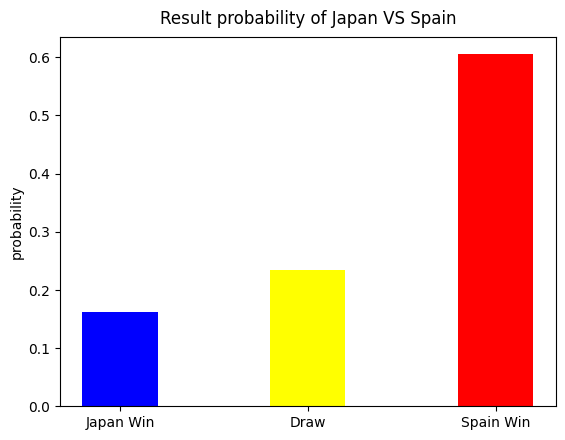

In [ ]:
A = Result_df.loc[Result_df['Home Team'] == 'Japan']
A = A.loc[A['Away Team'] == 'Spain']

data = {'Japan Win':A['Home Win rate'].values[0], 'Draw':A['Draw rate'].values[0], 'Spain Win':A['Home Lose rate'].values[0]}
number = list(data.keys())
values = list(data.values())
c = ['blue', 'yellow', 'red']

plt.bar(number, values, color = c, width = 0.4)
plt.title("Result probability of Japan VS Spain", y=1.012)
plt.ylabel("probability", labelpad=3);

plt.show()

In [ ]:
Label_name = ['Team1_Age','Team2_Age','GK_1','RB_1','CB1_1','CB2_1','LB_1','M1_1','M2_1','M3_1','M4_1','F1_1','F2_1','GK_2','RB_2','CB1_2','CB2_2','LB_2','M1_2','M2_2','M3_2','M4_2','F1_2','F2_2'] 